# P01 · Exploratory Data Analysis — Retail Moda Colombia

**Autor:** Mauricio Rodríguez  
**Proyecto:** Portafolio DS — Fase 1  
**Datos:** Dataset sintético de ventas retail (2022–2024) | 12 tiendas · 1,130 SKUs · 3 años  

---

## 🎯 Objetivo de negocio
Identificar patrones de ventas, estacionalidad, variabilidad entre tiendas y comportamiento de SKUs  
para sentar las bases del forecasting de demanda y predicción de quiebres de stock (Fase 2).

## 📋 Estructura del análisis
1. Carga y calidad de datos
2. Visión general de ingresos
3. Estacionalidad (anual, mensual, semanal)
4. Análisis por tienda y segmento
5. Análisis por categoría y SKU
6. Distribuciones y outliers
7. Correlaciones
8. Conclusiones y hallazgos clave

In [18]:
# ── IMPORTS ──────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Estilo global
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 5)
AZUL   = '#2563EB'
ROJO   = '#DC2626'
VERDE  = '#16A34A'
NARANJA= '#EA580C'

print('✅ Librerías cargadas')

✅ Librerías cargadas


---
## 1 · Carga y calidad de datos

In [19]:
# ── CARGA ─────────────────────────────────────────────────────────────
ventas    = pd.read_csv('data/fact_ventas.csv',      parse_dates=['fecha'])
inventario= pd.read_csv('data/fact_inventario.csv',  parse_dates=['fecha'])
skus      = pd.read_csv('data/dim_skus.csv')
tiendas   = pd.read_csv('data/dim_tiendas.csv')
calendario= pd.read_csv('data/dim_calendario.csv',   parse_dates=['fecha'])

print(f'fact_ventas:     {ventas.shape[0]:>7,} filas · {ventas.shape[1]} columnas')
print(f'fact_inventario: {inventario.shape[0]:>7,} filas · {inventario.shape[1]} columnas')
print(f'dim_skus:        {skus.shape[0]:>7,} filas · {skus.shape[1]} columnas')
print(f'dim_tiendas:     {tiendas.shape[0]:>7,} filas · {tiendas.shape[1]} columnas')
print(f'dim_calendario:  {calendario.shape[0]:>7,} filas · {calendario.shape[1]} columnas')
print(f'\nRango fechas: {ventas.fecha.min().date()} → {ventas.fecha.max().date()}')

fact_ventas:      47,040 filas · 11 columnas
fact_inventario:  94,200 filas · 9 columnas
dim_skus:          1,130 filas · 9 columnas
dim_tiendas:          12 filas · 8 columnas
dim_calendario:    1,096 filas · 13 columnas

Rango fechas: 2022-01-03 → 2024-12-30


In [20]:
# ── CALIDAD DE DATOS ──────────────────────────────────────────────────
print('=== NULOS en fact_ventas ===')
nulos = ventas.isnull().sum()
print(nulos[nulos > 0] if nulos.sum() > 0 else '✅ Sin valores nulos')

print('\n=== TIPOS DE DATOS ===')
print(ventas.dtypes)

print('\n=== ESTADÍSTICAS BÁSICAS (variables numéricas) ===')
ventas[['unidades','ingresos','margen_pct','descuento_pct']].describe().round(2)

=== NULOS en fact_ventas ===
✅ Sin valores nulos

=== TIPOS DE DATOS ===
fecha              datetime64[us]
tienda_id                     str
sku_id                        str
unidades                    int64
precio_unitario             int64
descuento_pct             float64
precio_final                int64
ingresos                    int64
costo_total                 int64
margen_bruto                int64
margen_pct                float64
dtype: object

=== ESTADÍSTICAS BÁSICAS (variables numéricas) ===


,unidades,ingresos,margen_pct,descuento_pct
count,47040.00,47040.00,47040.00,47040.00
mean,5.16,426073.81,0.52,0.05
std,6.04,593372.71,0.09,0.11
min,1.00,20500.00,0.07,0.00
25%,2.00,111000.00,0.51,0.00
50%,3.00,240000.00,0.55,0.00
75%,6.00,504925.00,0.55,0.10
max,133.00,14608000.00,0.57,0.50


In [21]:
# ── ENRIQUECER ventas con dimensiones ────────────────────────────────
# Unir categoría y segmento para análisis enriquecidos
ventas = (ventas
    .merge(skus[['sku_id','categoria','talla','color','temporada']], on='sku_id', how='left')
    .merge(tiendas[['tienda_id','ciudad','segmento','region','nivel_trafico']], on='tienda_id', how='left')
    .merge(calendario[['fecha','mes','nombre_mes','trimestre','semana',
                        'es_fin_semana','evento_especial','temporada_cal']]
           .rename(columns={'temporada_cal':'temporada_cal'})
           if 'temporada_cal' in calendario.columns
           else calendario[['fecha','mes','nombre_mes','trimestre','semana','es_fin_semana','evento_especial']],
           on='fecha', how='left')
)
ventas['año'] = ventas['fecha'].dt.year

print(f'✅ Ventas enriquecida: {ventas.shape[0]:,} filas · {ventas.shape[1]} columnas')
ventas.head(3)

✅ Ventas enriquecida: 47,040 filas · 26 columnas


,fecha,tienda_id,sku_id,unidades,precio_unitario,descuento_pct,precio_final,ingresos,costo_total,margen_bruto,...,segmento,region,nivel_trafico,mes,nombre_mes,trimestre,semana,es_fin_semana,evento_especial,año
0,2022-01-03,T08,SKU000246,5,99000,0.1,89100,445500,220000,225500,...,B,Costa,Medio,1,January,1,1,False,Ninguno,2022
1,2022-01-03,T04,SKU000395,4,74000,0.0,74000,296000,132000,164000,...,A,Occidente,Alto,1,January,1,1,False,Ninguno,2022
2,2022-01-03,T01,SKU000476,4,127000,0.0,127000,508000,228000,280000,...,A,Centro,Alto,1,January,1,1,False,Ninguno,2022


---
## 2 · Visión general de ingresos

In [22]:
# ── KPIs GLOBALES ────────────────────────────────────────────────────
total_ingresos  = ventas['ingresos'].sum()
total_unidades  = ventas['unidades'].sum()
margen_promedio = ventas['margen_pct'].mean()
ticket_promedio = ventas['precio_final'].mean()
skus_activos    = ventas['sku_id'].nunique()

print('━'*50)
print(f'  💰 Ingresos totales (3 años): ${total_ingresos/1e9:.2f}B COP')
print(f'  📦 Unidades vendidas:          {total_unidades:>12,}')
print(f'  📊 Margen bruto promedio:       {margen_promedio:.1%}')
print(f'  🏷  Ticket promedio:            ${ticket_promedio:>10,.0f} COP')
print(f'  🔖 SKUs con al menos 1 venta:  {skus_activos:>12,}')
print('━'*50)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  💰 Ingresos totales (3 años): $20.04B COP
  📦 Unidades vendidas:               242,601
  📊 Margen bruto promedio:       51.5%
  🏷  Ticket promedio:            $    82,539 COP
  🔖 SKUs con al menos 1 venta:         1,130
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


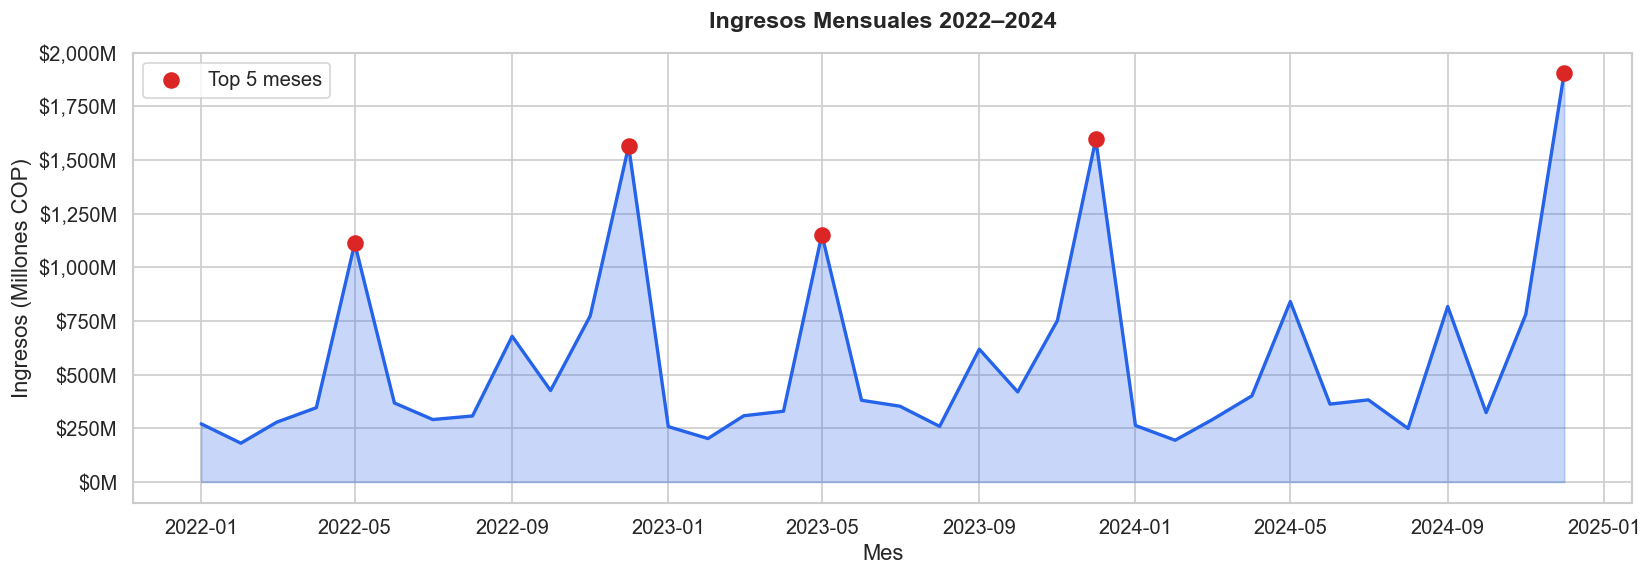


🔍 Top 5 meses por ingresos:
     fecha       ingresos
2024-12-01 $1,904,997,700
2023-12-01 $1,595,530,400
2022-12-01 $1,564,095,400
2023-05-01 $1,152,674,100
2022-05-01 $1,111,188,700


In [23]:
# ── INGRESOS MENSUALES (serie de tiempo) ─────────────────────────────
ingresos_mes = (ventas
    .groupby(ventas['fecha'].dt.to_period('M'))
    ['ingresos'].sum()
    .reset_index()
)
ingresos_mes['fecha'] = ingresos_mes['fecha'].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(ingresos_mes['fecha'], ingresos_mes['ingresos']/1e6,
                alpha=0.25, color=AZUL)
ax.plot(ingresos_mes['fecha'], ingresos_mes['ingresos']/1e6,
        color=AZUL, lw=2)

# Marcar meses pico
picos = ingresos_mes.nlargest(5, 'ingresos')
ax.scatter(picos['fecha'], picos['ingresos']/1e6,
           color=ROJO, zorder=5, s=80, label='Top 5 meses')

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}M'))
ax.set_title('Ingresos Mensuales 2022–2024', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Mes')
ax.set_ylabel('Ingresos (Millones COP)')
ax.legend()
plt.tight_layout()
plt.savefig('reports/01_ingresos_mensuales.png', bbox_inches='tight')
plt.show()

print('\n🔍 Top 5 meses por ingresos:')
print(picos[['fecha','ingresos']].assign(
    ingresos=lambda d: d['ingresos'].map('${:,.0f}'.format)
).to_string(index=False))

---
## 3 · Estacionalidad

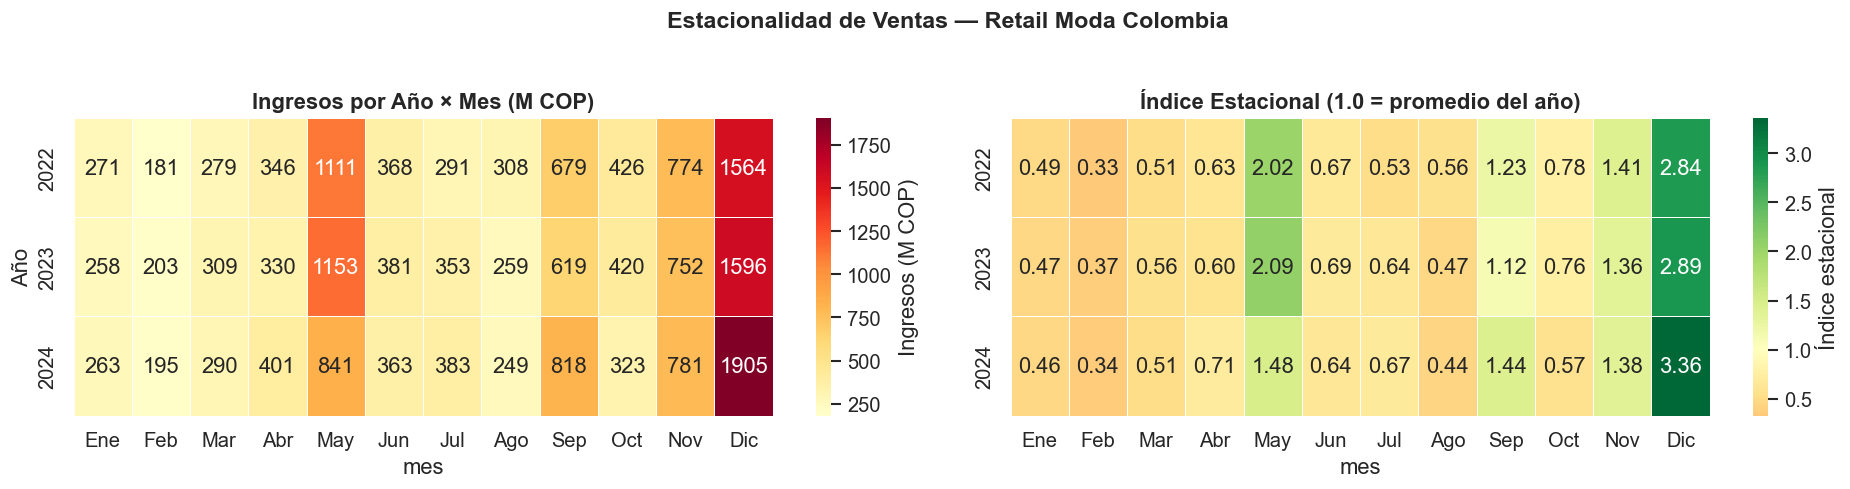

In [24]:
# ── ESTACIONALIDAD MENSUAL (heatmap año × mes) ───────────────────────
pivot_est = (ventas
    .groupby(['año','mes'])['ingresos']
    .sum()
    .unstack('mes')
)
# Normalizar por la media de cada año para ver patrón relativo
pivot_norm = pivot_est.div(pivot_est.mean(axis=1), axis=0)

meses_labels = ['Ene','Feb','Mar','Abr','May','Jun',
                 'Jul','Ago','Sep','Oct','Nov','Dic']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Heatmap absoluto
sns.heatmap(pivot_est/1e6, ax=axes[0], cmap='YlOrRd', annot=True,
            fmt='.0f', linewidths=0.5,
            xticklabels=meses_labels, cbar_kws={'label':'Ingresos (M COP)'})
axes[0].set_title('Ingresos por Año × Mes (M COP)', fontweight='bold')
axes[0].set_ylabel('Año')

# Heatmap normalizado (índice estacional)
sns.heatmap(pivot_norm, ax=axes[1], cmap='RdYlGn', annot=True,
            fmt='.2f', linewidths=0.5, center=1.0,
            xticklabels=meses_labels, cbar_kws={'label':'Índice estacional'})
axes[1].set_title('Índice Estacional (1.0 = promedio del año)', fontweight='bold')
axes[1].set_ylabel('')

plt.suptitle('Estacionalidad de Ventas — Retail Moda Colombia', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('reports/02_heatmap_estacionalidad.png', bbox_inches='tight')
plt.show()

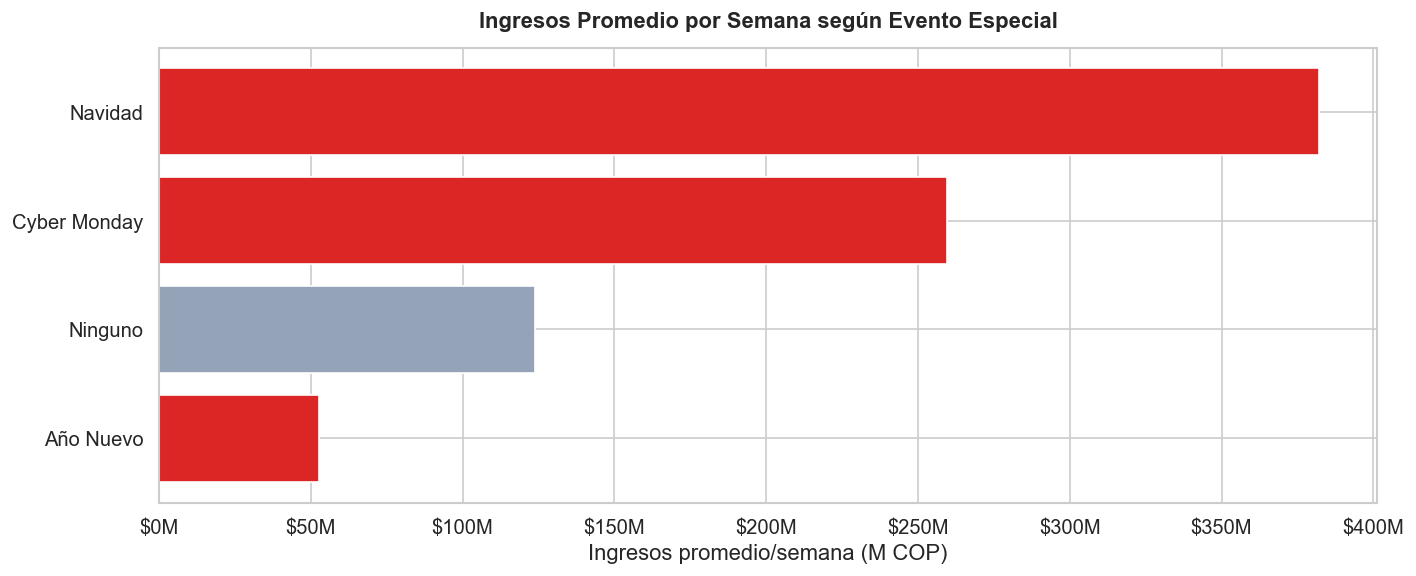

evento_especial ingresos_por_semana margen_prom
        Navidad        $382,123,800       51.8%
   Cyber Monday        $259,475,633       51.5%
        Ninguno        $123,877,734       51.5%
      Año Nuevo         $52,545,800       52.5%


In [25]:
# ── IMPACTO DE EVENTOS ESPECIALES ───────────────────────────────────
impacto_evento = (ventas
    .groupby('evento_especial')
    .agg(
        ingresos_totales=('ingresos','sum'),
        unidades_totales=('unidades','sum'),
        semanas=('fecha','nunique'),
        margen_prom=('margen_pct','mean')
    )
    .reset_index()
)
impacto_evento['ingresos_por_semana'] = (
    impacto_evento['ingresos_totales'] / impacto_evento['semanas']
)
impacto_evento = impacto_evento.sort_values('ingresos_por_semana', ascending=True)

fig, ax = plt.subplots(figsize=(12, 5))
colores = [ROJO if e != 'Ninguno' else '#94A3B8' 
           for e in impacto_evento['evento_especial']]
bars = ax.barh(impacto_evento['evento_especial'],
               impacto_evento['ingresos_por_semana']/1e6,
               color=colores)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'${x:.0f}M'))
ax.set_title('Ingresos Promedio por Semana según Evento Especial',
             fontweight='bold', pad=12)
ax.set_xlabel('Ingresos promedio/semana (M COP)')
plt.tight_layout()
plt.savefig('reports/03_impacto_eventos.png', bbox_inches='tight')
plt.show()

# Tabla resumen
print(impacto_evento[['evento_especial','ingresos_por_semana','margen_prom']]
      .sort_values('ingresos_por_semana', ascending=False)
      .assign(ingresos_por_semana=lambda d: d['ingresos_por_semana'].map('${:,.0f}'.format),
              margen_prom=lambda d: d['margen_prom'].map('{:.1%}'.format))
      .to_string(index=False))

---
## 4 · Análisis por tienda y segmento

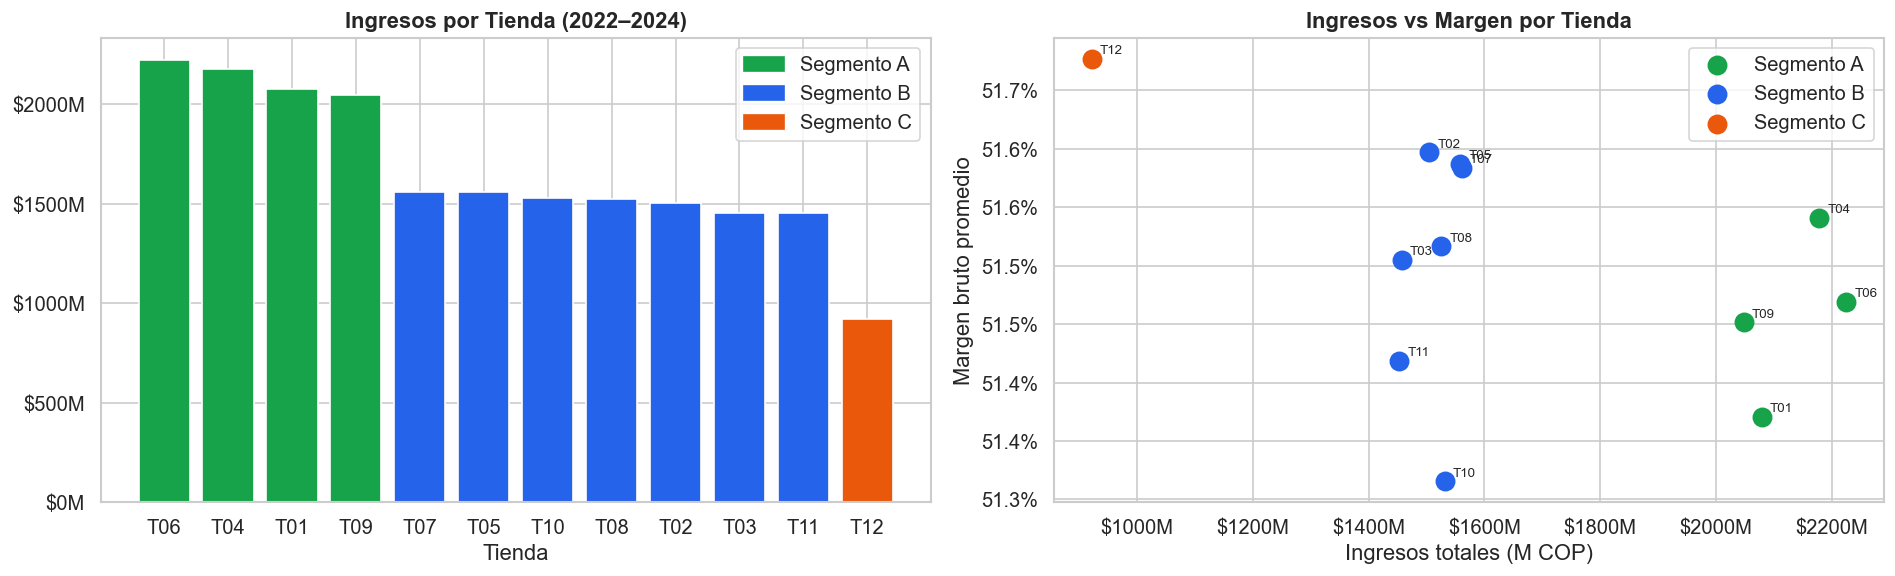

In [26]:
# ── INGRESOS POR TIENDA ───────────────────────────────────────────────
x_tienda = (ventas
    .groupby(['tienda_id','ciudad','segmento'])
    .agg(ingresos=('ingresos','sum'), margen=('margen_pct','mean'))
    .reset_index()
    .sort_values('ingresos', ascending=False)
)

colores_seg = {'A': VERDE, 'B': AZUL, 'C': NARANJA}
colores_barra = x_tienda['segmento'].map(colores_seg)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Barras ingresos
axes[0].bar(x_tienda['tienda_id'], x_tienda['ingresos']/1e6,
            color=colores_barra, edgecolor='white')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'${x:.0f}M'))
axes[0].set_title('Ingresos por Tienda (2022–2024)', fontweight='bold')
axes[0].set_xlabel('Tienda')
# Leyenda segmento
from matplotlib.patches import Patch
leyenda = [Patch(color=v, label=f'Segmento {k}') for k,v in colores_seg.items()]
axes[0].legend(handles=leyenda)

# Scatter ingresos vs margen
for seg, color in colores_seg.items():
    subset = x_tienda[x_tienda['segmento']==seg]
    axes[1].scatter(subset['ingresos']/1e6, subset['margen'],
                    color=color, s=120, label=f'Segmento {seg}', zorder=3)
    for _, row in subset.iterrows():
        axes[1].annotate(row['tienda_id'],
                         (row['ingresos']/1e6, row['margen']),
                         textcoords='offset points', xytext=(5, 3), fontsize=8)

axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{x:.1%}'))
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'${x:.0f}M'))
axes[1].set_title('Ingresos vs Margen por Tienda', fontweight='bold')
axes[1].set_xlabel('Ingresos totales (M COP)')
axes[1].set_ylabel('Margen bruto promedio')
axes[1].legend()

plt.tight_layout()
plt.savefig('reports/04_analisis_tiendas.png', bbox_inches='tight')
plt.show()

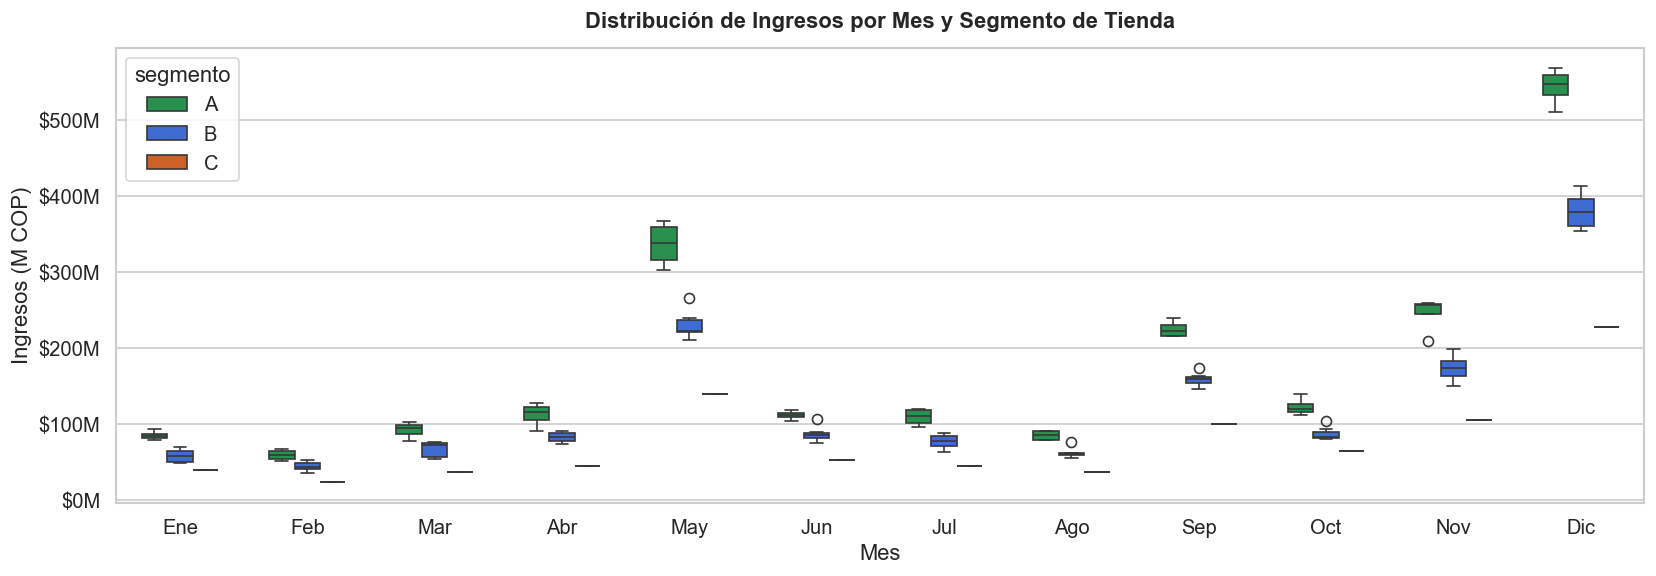

In [27]:
# ── VARIABILIDAD ENTRE TIENDAS (boxplot por mes) ──────────────────────
# Pregunta clave: ¿cuánto varía el desempeño entre tiendas en el mismo mes?
var_tienda = (ventas
    .groupby(['tienda_id','mes','segmento'])
    ['ingresos'].sum()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(data=var_tienda, x='mes', y='ingresos',
            hue='segmento', palette={'A':VERDE,'B':AZUL,'C':NARANJA},
            ax=ax, width=0.6)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'${x/1e6:.0f}M'))
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun',
                    'Jul','Ago','Sep','Oct','Nov','Dic'])
ax.set_title('Distribución de Ingresos por Mes y Segmento de Tienda',
             fontweight='bold', pad=12)
ax.set_xlabel('Mes')
ax.set_ylabel('Ingresos (M COP)')
plt.tight_layout()
plt.savefig('reports/05_variabilidad_tiendas.png', bbox_inches='tight')
plt.show()

---
## 5 · Análisis por categoría y SKU — Segmentación ABC

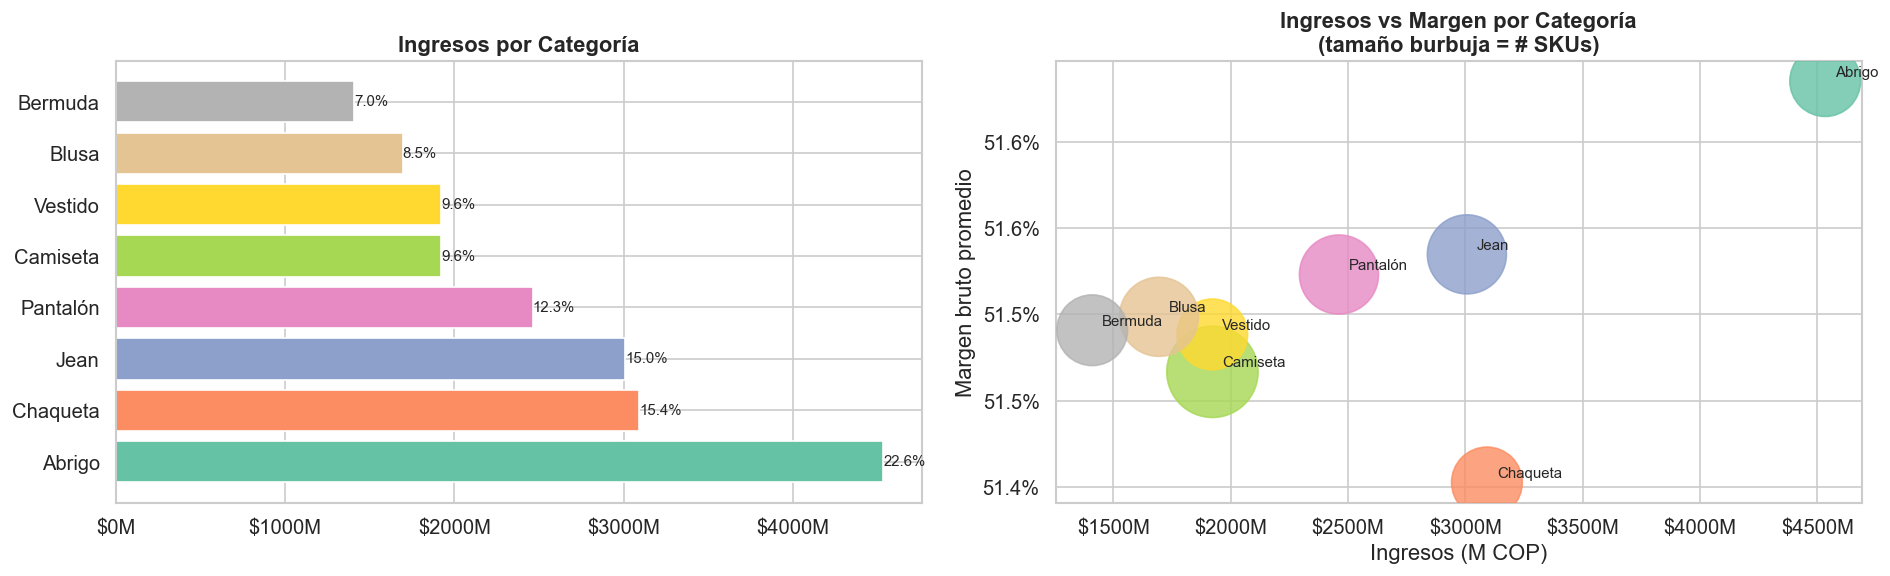

In [28]:
# ── INGRESOS POR CATEGORÍA ────────────────────────────────────────────
x_cat = (ventas
    .groupby('categoria')
    .agg(ingresos=('ingresos','sum'),
         unidades=('unidades','sum'),
         margen=('margen_pct','mean'),
         n_skus=('sku_id','nunique'))
    .reset_index()
    .sort_values('ingresos', ascending=False)
)
x_cat['participacion'] = x_cat['ingresos'] / x_cat['ingresos'].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Treemap simulado con barras apiladas
palette = sns.color_palette('Set2', len(x_cat))
axes[0].barh(x_cat['categoria'], x_cat['ingresos']/1e6,
             color=palette)
for i, (_, row) in enumerate(x_cat.iterrows()):
    axes[0].text(row['ingresos']/1e6 + 1, i,
                 f"{row['participacion']:.1%}", va='center', fontsize=9)
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'${x:.0f}M'))
axes[0].set_title('Ingresos por Categoría', fontweight='bold')

# Margen vs ingresos burbuja
sizes = x_cat['n_skus'] * 15
axes[1].scatter(x_cat['ingresos']/1e6, x_cat['margen'],
                s=sizes, c=range(len(x_cat)), cmap='Set2',
                alpha=0.8, zorder=3)
for _, row in x_cat.iterrows():
    axes[1].annotate(row['categoria'],
                     (row['ingresos']/1e6, row['margen']),
                     textcoords='offset points', xytext=(6, 3), fontsize=9)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{x:.1%}'))
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'${x:.0f}M'))
axes[1].set_title('Ingresos vs Margen por Categoría\n(tamaño burbuja = # SKUs)',
                  fontweight='bold')
axes[1].set_xlabel('Ingresos (M COP)')
axes[1].set_ylabel('Margen bruto promedio')

plt.tight_layout()
plt.savefig('reports/06_analisis_categorias.png', bbox_inches='tight')
plt.show()

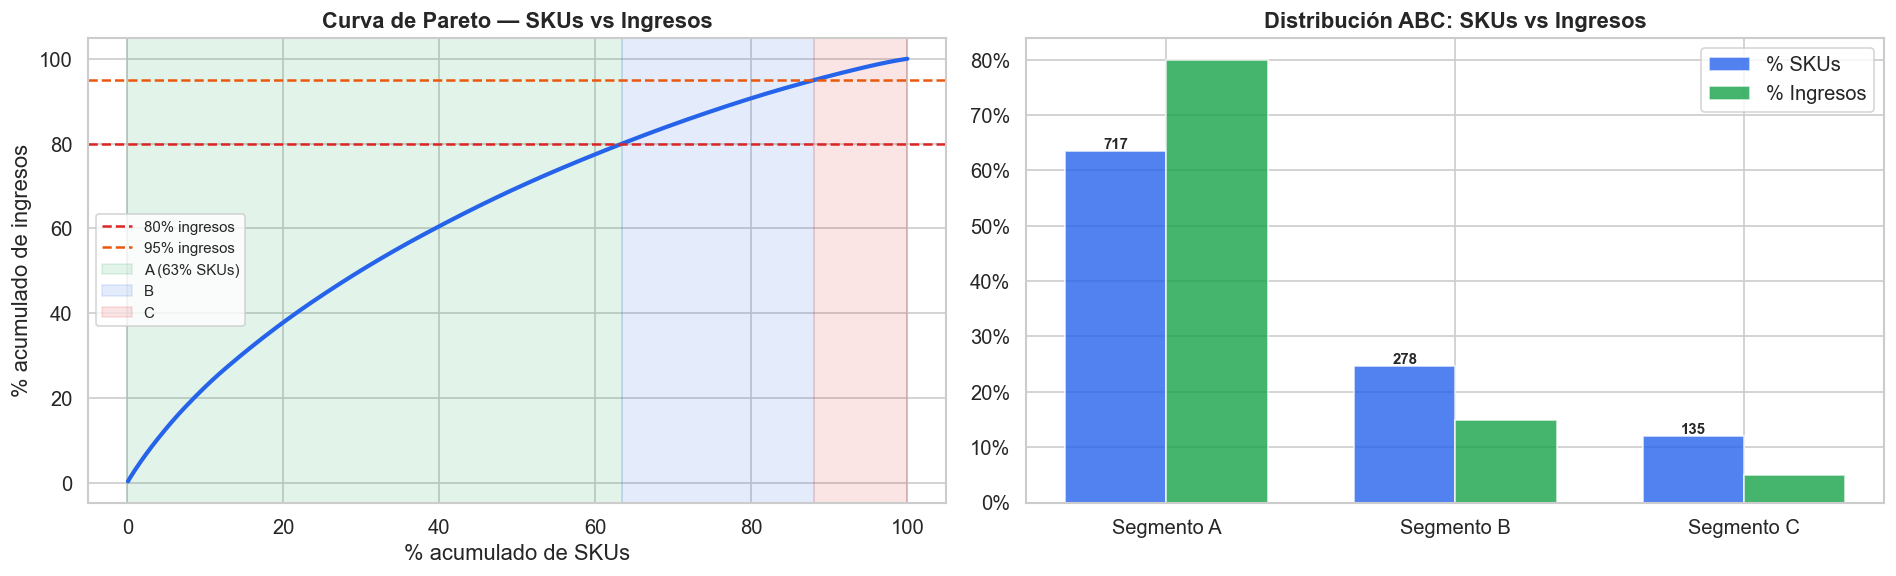


📊 Resumen segmentación ABC:
segmento_abc  n_skus        ingresos pct_skus pct_ingresos
           A     717 $16,033,075,100    63.5%        80.0%
           B     278  $3,005,414,200    24.6%        15.0%
           C     135  $1,004,022,700    11.9%         5.0%


In [29]:
# ── SEGMENTACIÓN ABC DE SKUs (Pareto) ────────────────────────────────
# Pregunta: ¿Qué % de SKUs genera el 80% de los ingresos?

x_sku = (ventas
    .groupby('sku_id')['ingresos']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
x_sku['pct_acumulado']     = x_sku['ingresos'].cumsum() / x_sku['ingresos'].sum()
x_sku['pct_skus']          = (x_sku.index + 1) / len(x_sku)
x_sku['segmento_abc'] = pd.cut(
    x_sku['pct_acumulado'],
    bins=[0, 0.8, 0.95, 1.0],
    labels=['A','B','C']
)

# Resumen ABC
abc_resumen = (x_sku
    .groupby('segmento_abc')
    .agg(n_skus=('sku_id','count'),
         ingresos=('ingresos','sum'))
    .reset_index()
)
abc_resumen['pct_skus']     = abc_resumen['n_skus'] / abc_resumen['n_skus'].sum()
abc_resumen['pct_ingresos'] = abc_resumen['ingresos'] / abc_resumen['ingresos'].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Curva de Pareto
axes[0].plot(x_sku['pct_skus']*100, x_sku['pct_acumulado']*100,
             color=AZUL, lw=2.5)
axes[0].axhline(80, color=ROJO, ls='--', lw=1.5, label='80% ingresos')
axes[0].axhline(95, color=NARANJA, ls='--', lw=1.5, label='95% ingresos')
# Sombrear zonas ABC
corte_a = x_sku[x_sku['pct_acumulado'] <= 0.80]['pct_skus'].max() * 100
corte_b = x_sku[x_sku['pct_acumulado'] <= 0.95]['pct_skus'].max() * 100
axes[0].axvspan(0, corte_a, alpha=0.12, color=VERDE, label=f'A ({corte_a:.0f}% SKUs)')
axes[0].axvspan(corte_a, corte_b, alpha=0.12, color=AZUL, label=f'B')
axes[0].axvspan(corte_b, 100, alpha=0.12, color=ROJO, label=f'C')
axes[0].set_xlabel('% acumulado de SKUs')
axes[0].set_ylabel('% acumulado de ingresos')
axes[0].set_title('Curva de Pareto — SKUs vs Ingresos', fontweight='bold')
axes[0].legend(fontsize=9)

# Barras comparativas ABC
x = range(len(abc_resumen))
w = 0.35
axes[1].bar([i-w/2 for i in x], abc_resumen['pct_skus']*100,
            width=w, label='% SKUs', color=AZUL, alpha=0.8)
axes[1].bar([i+w/2 for i in x], abc_resumen['pct_ingresos']*100,
            width=w, label='% Ingresos', color=VERDE, alpha=0.8)
axes[1].set_xticks(list(x))
axes[1].set_xticklabels([f'Segmento {s}' for s in abc_resumen['segmento_abc']])
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda v,_: f'{v:.0f}%'))
axes[1].set_title('Distribución ABC: SKUs vs Ingresos', fontweight='bold')
axes[1].legend()
for i, (_, row) in enumerate(abc_resumen.iterrows()):
    axes[1].text(i-w/2, row['pct_skus']*100+0.5, f"{row['n_skus']}",
                 ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/07_segmentacion_abc.png', bbox_inches='tight')
plt.show()

print('\n📊 Resumen segmentación ABC:')
print(abc_resumen.assign(
    pct_skus=lambda d: d['pct_skus'].map('{:.1%}'.format),
    pct_ingresos=lambda d: d['pct_ingresos'].map('{:.1%}'.format),
    ingresos=lambda d: d['ingresos'].map('${:,.0f}'.format)
).to_string(index=False))

---
## 6 · Distribuciones y Outliers

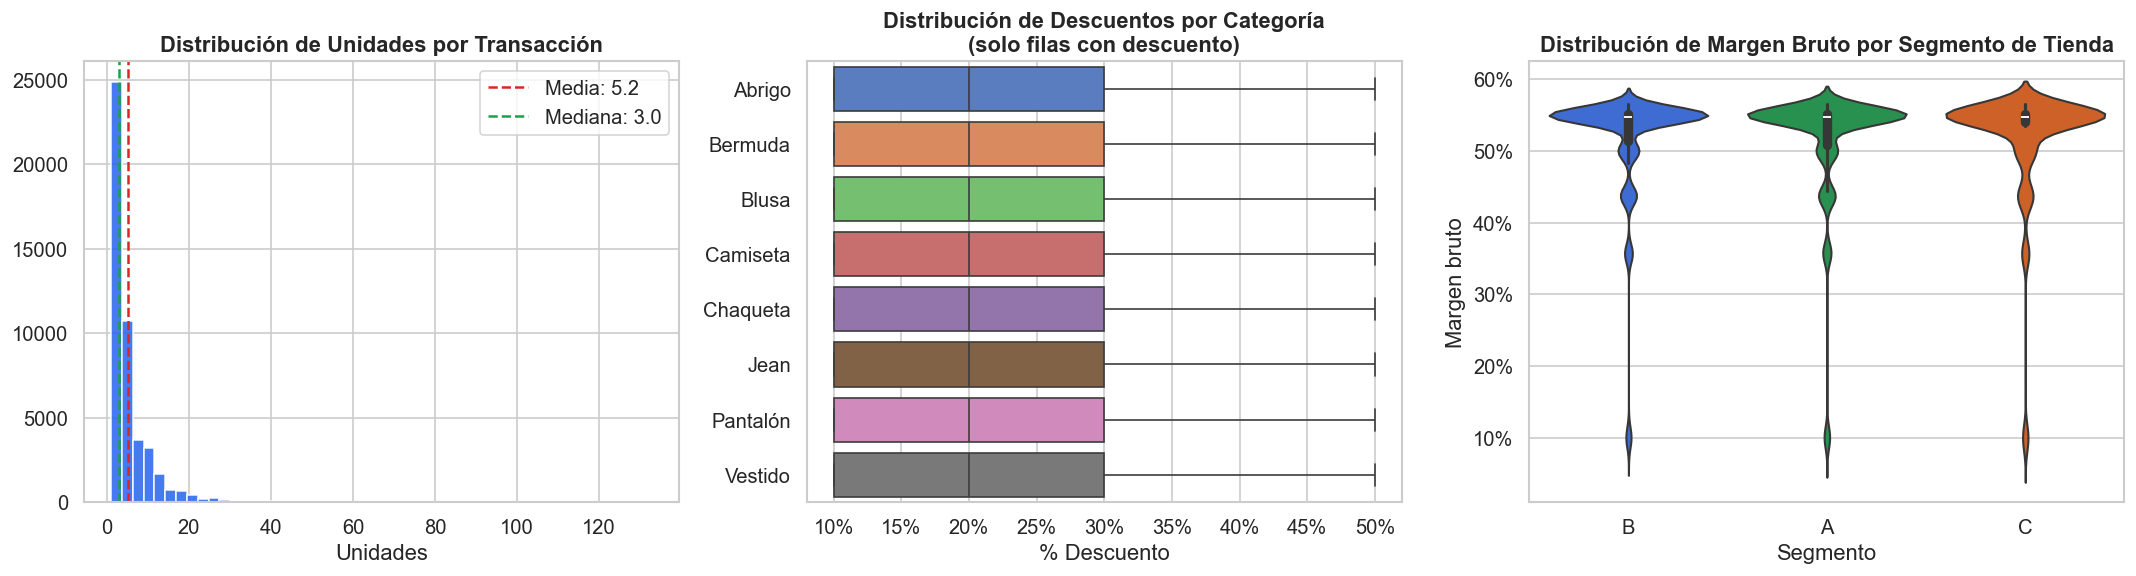

In [30]:
# ── DISTRIBUCIÓN DE UNIDADES VENDIDAS ────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma unidades
axes[0].hist(ventas['unidades'], bins=50, color=AZUL, edgecolor='white', alpha=0.85)
axes[0].axvline(ventas['unidades'].mean(), color=ROJO, ls='--',
                label=f"Media: {ventas['unidades'].mean():.1f}")
axes[0].axvline(ventas['unidades'].median(), color=VERDE, ls='--',
                label=f"Mediana: {ventas['unidades'].median():.1f}")
axes[0].set_title('Distribución de Unidades por Transacción', fontweight='bold')
axes[0].set_xlabel('Unidades')
axes[0].legend()

# Boxplot descuento por categoría
orden_cat = ventas.groupby('categoria')['descuento_pct'].median().sort_values().index
sns.boxplot(data=ventas[ventas['descuento_pct']>0],
            x='descuento_pct', y='categoria', order=orden_cat,
            palette='muted', ax=axes[1])
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{x:.0%}'))
axes[1].set_title('Distribución de Descuentos por Categoría\n(solo filas con descuento)',
                  fontweight='bold')
axes[1].set_xlabel('% Descuento')
axes[1].set_ylabel('')

# Boxplot margen por segmento
sns.violinplot(data=ventas, x='segmento', y='margen_pct',
               palette={'A':VERDE,'B':AZUL,'C':NARANJA},
               ax=axes[2], inner='box')
axes[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{x:.0%}'))
axes[2].set_title('Distribución de Margen Bruto por Segmento de Tienda',
                  fontweight='bold')
axes[2].set_xlabel('Segmento')
axes[2].set_ylabel('Margen bruto')

plt.tight_layout()
plt.savefig('reports/08_distribuciones_outliers.png', bbox_inches='tight')
plt.show()

In [31]:
# ── DETECCIÓN DE OUTLIERS (IQR) ───────────────────────────────────────
def detectar_outliers_iqr(serie, nombre):
    Q1, Q3 = serie.quantile(0.25), serie.quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    outliers = serie[(serie < limite_inf) | (serie > limite_sup)]
    pct = len(outliers) / len(serie)
    print(f"  {nombre:<20} | Q1={Q1:>8.1f} | Q3={Q3:>8.1f} | IQR={IQR:>8.1f} "
          f"| Outliers: {len(outliers):>5,} ({pct:.1%})")
    return outliers

print('=== ANÁLISIS DE OUTLIERS (método IQR) ===')
print(f"  {'Variable':<20} | {'Q1':>8} | {'Q3':>8} | {'IQR':>8} | Outliers")
print('-'*75)
for col in ['unidades','ingresos','margen_pct','descuento_pct']:
    detectar_outliers_iqr(ventas[col], col)

print('\n💡 Insight: Los outliers en unidades corresponden a compras corporativas o')
print('   eventos especiales — no son errores de datos sino patrones de negocio.')

=== ANÁLISIS DE OUTLIERS (método IQR) ===
  Variable             |       Q1 |       Q3 |      IQR | Outliers
---------------------------------------------------------------------------
  unidades             | Q1=     2.0 | Q3=     6.0 | IQR=     4.0 | Outliers: 3,837 (8.2%)
  ingresos             | Q1=111000.0 | Q3=504925.0 | IQR=393925.0 | Outliers: 3,736 (7.9%)
  margen_pct           | Q1=     0.5 | Q3=     0.6 | IQR=     0.0 | Outliers: 7,021 (14.9%)
  descuento_pct        | Q1=     0.0 | Q3=     0.1 | IQR=     0.1 | Outliers: 3,264 (6.9%)

💡 Insight: Los outliers en unidades corresponden a compras corporativas o
   eventos especiales — no son errores de datos sino patrones de negocio.


---
## 7 · Correlaciones

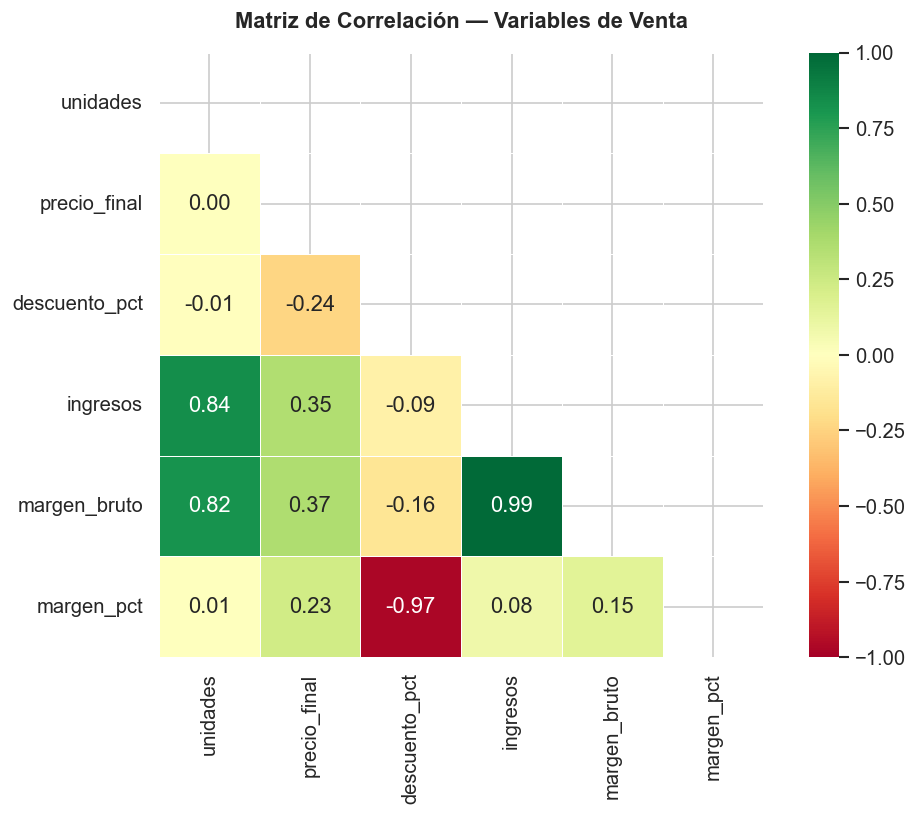


🔍 Correlaciones clave para el modelo predictivo:
         var1          var2  correlacion
 margen_bruto      ingresos     0.992110
   margen_pct descuento_pct    -0.973986
     ingresos      unidades     0.840244
 margen_bruto      unidades     0.819493
 margen_bruto  precio_final     0.365444
     ingresos  precio_final     0.354217
descuento_pct  precio_final    -0.240725
   margen_pct  precio_final     0.233659


In [32]:
# ── MATRIZ DE CORRELACIÓN ─────────────────────────────────────────────
vars_corr = ['unidades','precio_final','descuento_pct',
             'ingresos','margen_bruto','margen_pct']
corr_matrix = ventas[vars_corr].corr()

fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdYlGn', center=0, square=True,
            linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Matriz de Correlación — Variables de Venta', fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('reports/09_correlaciones.png', bbox_inches='tight')
plt.show()

# Correlaciones más relevantes
print('\n🔍 Correlaciones clave para el modelo predictivo:')
corr_flat = (corr_matrix
    .where(mask == False)
    .stack()
    .reset_index()
    .rename(columns={0:'correlacion','level_0':'var1','level_1':'var2'})
    .assign(abs_corr=lambda d: d['correlacion'].abs())
    .sort_values('abs_corr', ascending=False)
    .head(8)
)
print(corr_flat[['var1','var2','correlacion']].to_string(index=False))

---
## 8 · Conclusiones y hallazgos clave

> Esta sección es la más importante del notebook para el reclutador —  
> demuestra pensamiento de negocio, no solo código.

In [33]:
# ── RESUMEN EJECUTIVO AUTOMATIZADO ───────────────────────────────────
# Calcular hallazgos clave
mes_pico = ingresos_mes.loc[ingresos_mes['ingresos'].idxmax()]
mes_bajo = ingresos_mes.loc[ingresos_mes['ingresos'].idxmin()]
ratio_estacional = mes_pico['ingresos'] / mes_bajo['ingresos']

top_tienda  = x_tienda.iloc[0]
low_tienda  = x_tienda.iloc[-1]
ratio_tiend = top_tienda['ingresos'] / low_tienda['ingresos']

abc_a = abc_resumen[abc_resumen['segmento_abc']=='A'].iloc[0]

print('='*60)
print('  📊 HALLAZGOS CLAVE — P01 EDA Ventas Retail')
print('='*60)
print(f"""
1. ESTACIONALIDAD PRONUNCIADA
   • El mes más alto supera al más bajo en {ratio_estacional:.1f}x
   • Diciembre y Mayo (Día Madre) son los picos críticos
   • Impacto directo: el forecast debe capturar estos patrones
     o producirá errores de hasta {(ratio_estacional-1)*100:.0f}% en meses extremos

2. ALTA VARIABILIDAD ENTRE TIENDAS
   • La tienda top ({top_tienda['tienda_id']}) genera {ratio_tiend:.1f}x más que la menor
   • La variabilidad no se explica solo por segmento — hay
     factores operacionales a investigar
   • Oportunidad: replicar prácticas de tiendas A en segmento B

3. PARETO DE SKUs
   • Solo el {abc_a['pct_skus']:.1%} de los SKUs genera el 80% del ingreso (Seg. A)
   • {abc_a['n_skus']} SKUs críticos deben tener prioridad de reabastecimiento
   • Base directa para el modelo de predicción de quiebre de stock (P04)

4. DESCUENTOS Y MARGEN
   • Los eventos especiales muestran mayor margen promedio que
     semanas regulares — el cliente compra a precio completo
   • El descuento no siempre corre con mayor volumen de unidades
     (correlación baja) — revisar política de descuentos por segmento

5. IMPLICACIONES PARA FASES 2–3
   • Features para ML: mes, semana, evento_especial, segmento_tienda,
     categoria, es_sku_a, stock_disponible_semana_anterior
   • Métrica de negocio: el error en meses pico tiene 3x más impacto
     que en meses normales → usar WMAPE ponderado
""")
print('='*60)

  📊 HALLAZGOS CLAVE — P01 EDA Ventas Retail

1. ESTACIONALIDAD PRONUNCIADA
   • El mes más alto supera al más bajo en 10.5x
   • Diciembre y Mayo (Día Madre) son los picos críticos
   • Impacto directo: el forecast debe capturar estos patrones
     o producirá errores de hasta 952% en meses extremos

2. ALTA VARIABILIDAD ENTRE TIENDAS
   • La tienda top (T06) genera 2.4x más que la menor
   • La variabilidad no se explica solo por segmento — hay
     factores operacionales a investigar
   • Oportunidad: replicar prácticas de tiendas A en segmento B

3. PARETO DE SKUs
   • Solo el 63.5% de los SKUs genera el 80% del ingreso (Seg. A)
   • 717 SKUs críticos deben tener prioridad de reabastecimiento
   • Base directa para el modelo de predicción de quiebre de stock (P04)

4. DESCUENTOS Y MARGEN
   • Los eventos especiales muestran mayor margen promedio que
     semanas regulares — el cliente compra a precio completo
   • El descuento no siempre corre con mayor volumen de unidades
     (cor

In [35]:
import os
os.makedirs('reports', exist_ok=True)

# Guardar como CSV en lugar de parquet (más compatible)
ventas.to_csv('data/fact_ventas_enriquecida.csv', index=False)

# Guardar segmentación ABC para usar en P02, P04
x_sku[['sku_id','ingresos','pct_acumulado','segmento_abc']].to_csv(
    'data/sku_segmentacion_abc.csv', index=False)

print('✅ Archivos guardados:')
print('   data/fact_ventas_enriquecida.csv')
print('   data/sku_segmentacion_abc.csv')
print('\n🚀 Siguiente proyecto: P02 Dashboard Analítico con Storytelling')

✅ Archivos guardados:
   data/fact_ventas_enriquecida.csv
   data/sku_segmentacion_abc.csv

🚀 Siguiente proyecto: P02 Dashboard Analítico con Storytelling
